Fitted model: Price = 38,131.44 + (115.54 * Area) + (10,247.98 * Bedrooms)


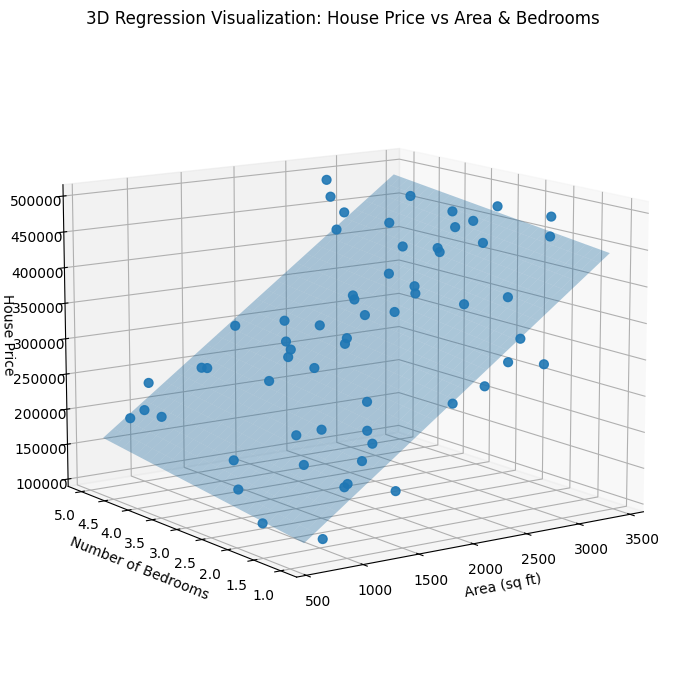

In [6]:
"""
3D visualization of a regression model for house price prediction.

Features:
- Area (sq ft)                 -> X-axis
- Number of Bedrooms           -> Y-axis
- House Price                  -> Z-axis (target)

What this script does:
1) Creates a sample dataset (replace with your real data).
2) Fits a linear regression plane: Price = b0 + b1*Area + b2*Bedrooms
3) Plots a 3D scatter (data points) + the fitted regression surface.
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def fit_plane_least_squares(area: np.ndarray, beds: np.ndarray, price: np.ndarray):
    """
    Fits: price = b0 + b1*area + b2*beds using least squares.
    Returns (b0, b1, b2).
    """
    # Design matrix with intercept
    X = np.column_stack([np.ones_like(area), area, beds])
    beta, *_ = np.linalg.lstsq(X, price, rcond=None)
    b0, b1, b2 = beta
    return float(b0), float(b1), float(b2)


def main():
    # ------------------------------------------------------------
    # 1) Example dataset (REPLACE with your real data arrays)
    # ------------------------------------------------------------
    rng = np.random.default_rng(42)

    # Simulated features
    n = 60
    area = rng.uniform(600, 3500, size=n)              # sq ft
    beds = rng.integers(1, 6, size=n)                  # bedrooms (1..5)

    # Simulated price with some noise (in $)
    # Underlying "true" relationship for demo purposes only:
    price = 20000 + 120 * area + 15000 * beds + rng.normal(0, 39000, size=n)

    # ------------------------------------------------------------
    # 2) Fit regression plane
    # ------------------------------------------------------------
    b0, b1, b2 = fit_plane_least_squares(area, beds, price)
    print(f"Fitted model: Price = {b0:,.2f} + ({b1:,.2f} * Area) + ({b2:,.2f} * Bedrooms)")

    # ------------------------------------------------------------
    # 3) Build a grid for the regression surface
    # ------------------------------------------------------------
    area_grid = np.linspace(area.min(), area.max(), 30)
    beds_grid = np.linspace(beds.min(), beds.max(), 30)
    A, B = np.meshgrid(area_grid, beds_grid)

    Z = b0 + b1 * A + b2 * B

    # ------------------------------------------------------------
    # 4) Plot: 3D scatter + regression surface
    # ------------------------------------------------------------
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Scatter points (observations)
    ax.scatter(area, beds, price, s=40, alpha=0.9)

    # Regression plane (surface)
    ax.plot_surface(A, B, Z, alpha=0.35, rstride=1, cstride=1)

    ax.set_title("3D Regression Visualization: House Price vs Area & Bedrooms")
    ax.set_xlabel("Area (sq ft)")
    ax.set_ylabel("Number of Bedrooms")
    ax.set_zlabel("House Price")

    # Optional: nicer viewing angle
    ax.view_init(elev=12, azim=235)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
